In [26]:
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# Устанавливаем логгер для детектрона
import detectron2

# Для печати логов
from detectron2.utils.logger import setup_logger

# Инициализируем логгер
setup_logger()

# Зоопарк моделей (по аналогии с torchvision.models)
from detectron2 import model_zoo

# Отдельный класс для предикта разными моделями
from detectron2.engine import DefaultPredictor

# Всея конфиг: все будем делать через него
from detectron2.config import get_cfg

# Для визуализации
from detectron2.utils.visualizer import Visualizer

# Для собственного датасета
from detectron2.data import MetadataCatalog, DatasetCatalog

import torch
import torch.nn.functional as F

from detectron2.structures import Boxes

from pathlib import Path
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

from roboflow import Roboflow

In [27]:
class DetectronHandler:

    def __init__(
        self, model_name: Path, confidence_threshold, model_weights=None
    ) -> None:

        self.cfg = get_cfg()
        # Загружаем предобученную конфигурацию модели
        self.cfg.merge_from_file(model_zoo.get_config_file(model_name))
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
            confidence_threshold  # Порог уверенности для инференса
        )
        if model_weights is not None:
            self.cfg.MODEL.WEIGHTS = os.path.join(
                self.cfg.OUTPUT_DIR, "model_final.pth"
            )
        else:
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
                model_name
            )  # Вес модели
        self.predictor = DefaultPredictor(self.cfg)
        self.dataset_registered = False

    def predict_and_visualize(self, image_path, show=True, save_path=None):

        # Загружаем изображение
        img_bgr = cv2.imread(image_path)

        # img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        outputs = self.predictor(img_bgr)

        # Визуализация результатов
        v = Visualizer(
            img_bgr[:, :, ::-1],
            metadata=MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]),
            scale=1.0,
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        result_img = out.get_image()

        if show:
            plt.figure(figsize=(12, 8))
            plt.imshow(result_img)
            plt.axis("off")
            plt.show()

        if save_path:
            cv2.imwrite(save_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
        return outputs

    def load_dataset_from_roboflow(self, api_key, workspace, project_name, version):
        """
        Загружает датасет из Roboflow с разделением на train/valid/test и регистрирует сплиты.
        Сохраняет атрибуты класса для дальнейшего использования.
        """
        from roboflow import Roboflow

        rf = Roboflow(api_key=api_key)
        project = rf.workspace(workspace).project(project_name)
        dataset = project.version(version).download("coco")  # COCO формат

        self.datasets = {}  # словарь для хранения имен и путей сплитов

        for split in ["train", "valid", "test"]:
            if split in dataset:
                dataset_name = f"{project_name}_{split}"
                json_file = dataset[split]["annotations"]
                image_root = dataset[split]["images"]

                register_coco_instances(dataset_name, {}, json_file, image_root)

                # Сохраняем информацию в словарь
                self.datasets[split] = {
                    "name": dataset_name,
                    "json": json_file,
                    "images": image_root,
                }

                print(
                    f"Датасет '{dataset_name}' зарегистрирован. Аннотации: {json_file}, Изображения: {image_root}"
                )

        self.dataset_registered = True
        return self.datasets

    def train_on_dataset(
        self,
        num_classes,
        max_iter=1000,
        num_workers=2,
        ims_per_batch=2,
        base_lr=0.00025,
    ):
        from detectron2.engine import DefaultTrainer

        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)
        self.cfg.DATALOADER.NUM_WORKERS = num_workers
        self.cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
        self.cfg.SOLVER.BASE_LR = base_lr
        self.cfg.SOLVER.MAX_ITER = max_iter

        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = (
            num_classes  # количество классов в вашем датасете
        )

        if not hasattr(self.cfg.MODEL, "WEIGHTS") or self.cfg.MODEL.WEIGHTS is None:
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
                "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
            )

        if self.dataset_registered:
            if "train" in self.datasets and "valid" in self.datasets:
                self.cfg.DATASETS.TRAIN = (self.datasets["train"]["name"],)
                self.cfg.DATASETS.TEST = (self.datasets["valid"]["name"],)
            else:
                print("Dataset does not contain 'train' or 'valid' splits")
                return
        else:
            print("No registered dataset")
            return

        trainer = DefaultTrainer(self.cfg)
        trainer.resume_or_load(resume=False)
        trainer.train()

In [28]:
test = DetectronHandler("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", 0.7)

[09/17 19:56:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


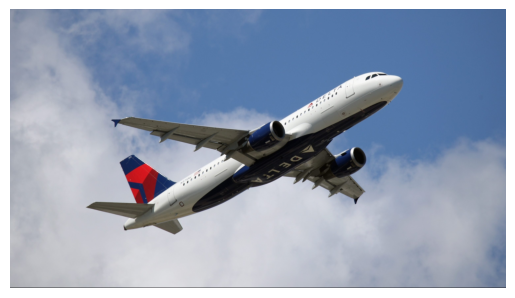

In [29]:
im = cv2.imread("./input.jpg")
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)  # BlueGreenRed -> RedGreenBlue (=torch.permute)
plt.axis("off")
plt.show()

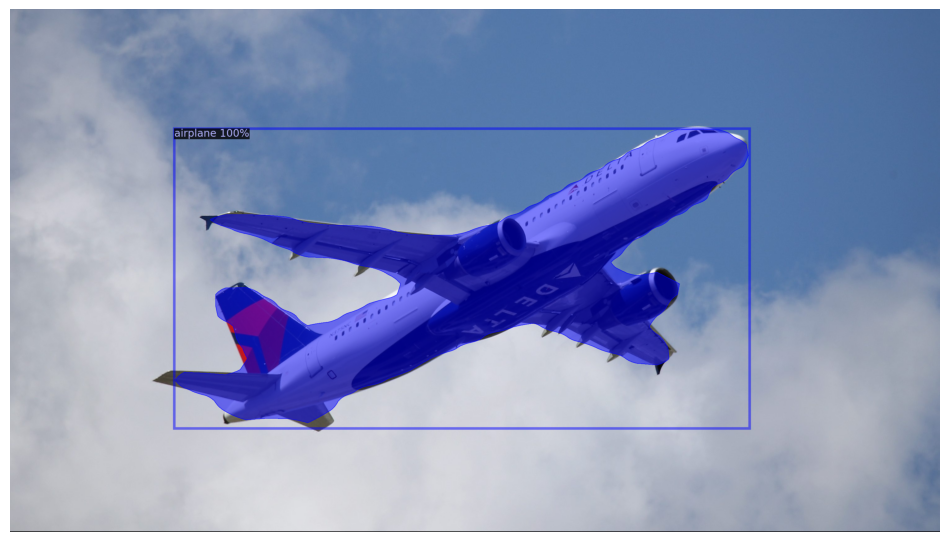

{'instances': Instances(num_instances=1, image_height=1687, image_width=3000, fields=[pred_boxes: Boxes(tensor([[ 529.5328,  385.9832, 2385.9766, 1352.5323]], device='cuda:0')), scores: tensor([0.9979], device='cuda:0'), pred_classes: tensor([4], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]], device='cuda:0')])}

In [30]:
test.predict_and_visualize("./input.jpg")